![Semillero Astrofisica](../logo.PNG)

---
# **Ecuacion diferencial ordinaria con condición de frontera**

David Felipe Bambague (dbambague@unal.edu.co)

Carlos Andrés del Valle (cdelv@unal.edu.co)

---

In [2]:
import numpy as np

 Vamos a resolver la ecuación difrerncial que da cuenta de las oscilaciones de una viga con extremo fijo y extremo libre.

  \begin{equation*}
      y^{\prime\prime} -4y =0
  \end{equation*}

  Las condiciones de frontera del problema son:

  \begin{align*}
      y(0)=0 && y(1)=5
  \end{align*}

  La solución analitica es:

  \begin{equation*}
    \frac{5}{sinh(2)}sinh(2*x)
  \end{equation*}

  

In [3]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



## **1. Definir la Ecuación a Resolver**

In [4]:
def ode(x,y):
    dy_dx = dde.grad.jacobian(y,x)
    d2y_dx2 = dde.grad.hessian(y,x)
    return  d2y_dx2 - 4*y
  

## **2. Definir Dominio de la Ecuación**

Dado que estamos tratando con una ecuacion diferencial ordinaria, podemos hacer usu de el dominio definido por .TimeDomain()

~~~python
class deepxde.geometry.timedomain.TimeDomain(t0, t1)
~~~

Esta clase de dominio crea el booleano para definir las coondiciones iniciales

~~~pyhton
on_initial(t)
~~~

In [5]:
geom = dde.geometry.TimeDomain(0, 1)

## **3. Definir Condiciones de Frontera**

Como estamos resolviendo una ODE, las condiciones de frontera se pueden entender como condiciones iniciales especificando el punto del dominio donde se quieren aplicar.

~~~python
class deepxde.icbc.initial_conditions.IC(geom, 
                                         func, 
                                         on_initial, 
                                         component=0)
~~~

Initial conditions: y([x, t0]) = func([x, t0])

In [6]:
IC1 = dde.icbc.IC(geom, lambda x: 0, lambda x, on_initial: np.isclose(x[0], 0))
IC2 = dde.icbc.IC(geom, lambda x: 5, lambda x, on_initial: np.isclose(x[0], 1))

## **4. Crear Datos de Entrenamiento**

vamos a crear los datos de entrenamiento

~~~python
class deepxde.data.pde.TimePDE(geometryxtime, 
                               pde, 
                               ic_bcs, 
                               num_domain=0, 
                               num_boundary=0, 
                               num_initial=0, 
                               train_distribution='Hammersley', 
                               anchors=None, 
                               exclusions=None, 
                               solution=None, 
                               num_test=None, 
                               auxiliary_var_function=None
~~~

Detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html?highlight=data.TimePDE#deepxde.data.pde.TimePDE. 

In [7]:
def func(x):
    return (5/np.sinh(2))*np.sinh(2*x)

data = dde.data.PDE(geom, ode, [IC1,IC2], 14, 4, solution=func, num_test=100)

## **5. Crear la Red Neuronal**

Vamos a utilizar una **Fully-connected neural network**.

~~~python
class deepxde.nn.tensorflow.fnn.FNN(layer_sizes, activation, 
                                    kernel_initializer, 
                                    regularization=None, 
                                    dropout_rate=0)
~~~

In [8]:
layer_size = [1] + [20]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## **6. Compilar y Entrenar el Modelo**

In [9]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.065955 s



c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.440215 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.38e-03, 0.00e+00, 2.51e+01]    [1.11e-03, 0.00e+00, 2.51e+01]    [1.00e+00]    
1000      [1.31e-03, 3.77e-06, 8.65e-06]    [3.02e-02, 3.77e-06, 8.65e-06]    [1.17e-03]    
2000      [3.79e-04, 5.46e-07, 5.37e-07]    [1.11e-02, 5.46e-07, 5.37e-07]    [3.69e-04]    
3000      [5.50e-04, 4.78e-06, 1.54e-05]    [7.78e-03, 4.78e-06, 1.54e-05]    [1.50e-03]    
4000      [1.05e-04, 5.26e-08, 9.31e-07]    [4.20e-03, 5.26e-08, 9.31e-07]    [4.22e-04]    
5000      [4.58e-05, 9.95e-08, 7.44e-09]    [2.67e-03, 9.95e-08, 7.44e-09]    [1.27e-04]    
6000      [3.63e-02, 8.49e-04, 9.29e-04]    [2.32e-02, 8.49e-04, 9.29e-04]    [1.31e-02]    
7000      [6.36e-03, 2.40e-04, 3.33e-04]    [8.74e-03, 2.40e-04, 3.33e-04]    [7.02e-03]    
8000      [1.40e-04, 3.41e-06, 6.38e-06]    [8.81e-04, 3.41e-06, 6.38e-06]    [8.55e-04]   

## **7. Graficar Solucion**

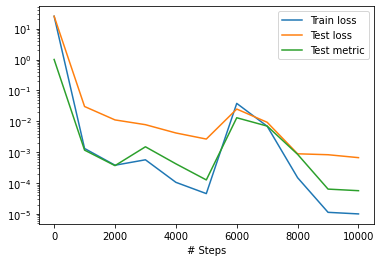

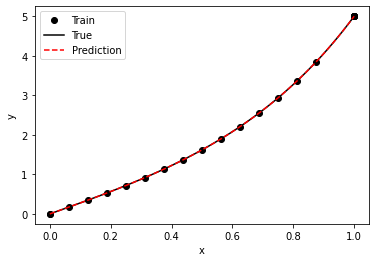

In [10]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)
